# The Complete Guide to Machine Learning on AWS with Amazon SageMaker

In [10]:
import pandas as pd

beans = pd.read_excel("./Dry_Bean_Dataset.xlsx")
beans.to_csv( "./dry_bean.csv", index=False)

In [ ]:
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

In [ ]:
sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()

In [ ]:
region = sess.boto_session.region_name
BUCKET_URI = "s3://mlops-dry-bean-bucket/dry_bean.csv"
BUCKET_NAME = "mlops-dry-bean-bucket"
DATASET_PATH = f"{BUCKET_URI}/dry_bean.csv"
TARGET_NAME = "Class"

In [12]:
#dry_bean = pd.read_csv(DATASET_PATH)
dry_bean = pd.read_csv("./dry_bean.csv")
dry_bean.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [13]:
dry_bean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

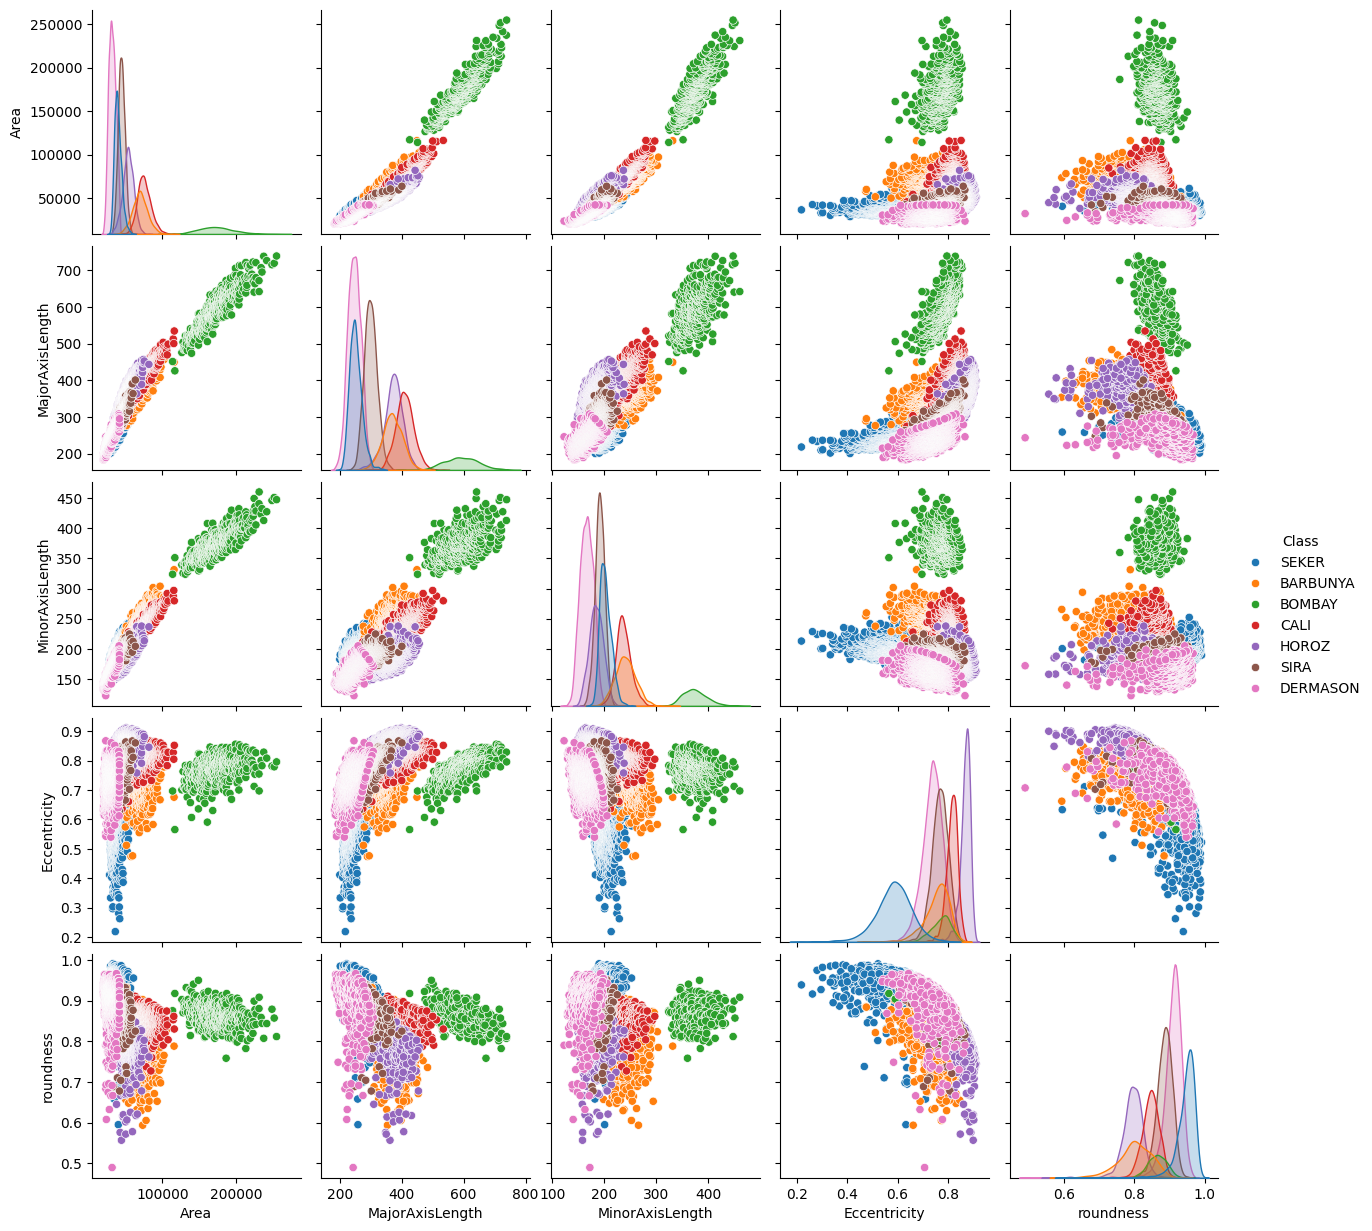

In [14]:
import seaborn as sns

sns.pairplot(
   dry_bean,
   vars=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "roundness"],
   hue="Class",
);

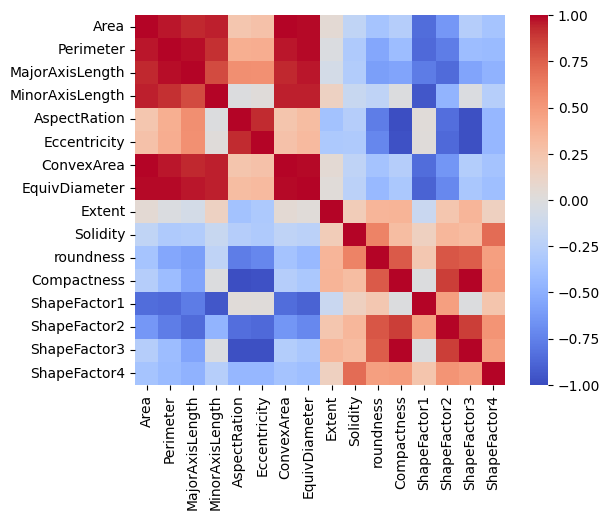

In [15]:
import matplotlib.pyplot as plt

correlation = dry_bean.corr(numeric_only=True)

# Create a square heatmap with center at 0
sns.heatmap(correlation, center=0, square=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

# For preprocessing
df = dry_bean.copy(deep=True)

# Encode the target
TARGET_NAME = "Class"
le = LabelEncoder()
df[TARGET_NAME] = le.fit_transform(df[TARGET_NAME])

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into two sets
train, test = train_test_split(df, random_state=1, test_size=0.2)

In [20]:
train.to_csv("dry-bean-train.csv")
test.to_csv("dry-bean-test.csv")

In [ ]:
# Send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
   path="dry-bean-train.csv",
   bucket=BUCKET_NAME,
   key_prefix="sagemaker/sklearncontainer",
)

testpath = sess.upload_data(
   path="dry-bean-test.csv",
   bucket=BUCKET_NAME,
   key_prefix="sagemaker/sklearncontainer",
)

In [21]:
%%writefile script.py

import argparse
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

if __name__ == "__main__":
   print("extracting arguments")
   parser = argparse.ArgumentParser()

   # Hyperparameters sent by the client are passed as command-line arguments to the script.
   parser.add_argument("--n-estimators", type=int, default=10)
   parser.add_argument("--min-samples-leaf", type=int, default=3)

   # Data, model, and output directories
   parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
   parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
   parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
   parser.add_argument("--train-file", type=str, default="dry-bean-train.csv")
   parser.add_argument("--test-file", type=str, default="dry-bean-test.csv")
   args, _ = parser.parse_known_args()
   
   print("reading data")

   train_df = pd.read_csv(os.path.join(args.train, args.train_file))
   test_df = pd.read_csv(os.path.join(args.test, args.test_file))

   print("building training and testing datasets")

   X_train = train_df.drop("Class", axis=1)
   X_test = test_df.drop("Class", axis=1)
   y_train = train_df[["Class"]]
   y_test = test_df[["Class"]]

   # Train model
   print("training model")

   model = RandomForestClassifier(
       n_estimators=args.n_estimators,
       min_samples_leaf=args.min_samples_leaf,
       n_jobs=-1,
   )

   model.fit(X_train, y_train)

   # Print abs error
   print("validating model")

   bal_acc_train = balanced_accuracy_score(y_train, model.predict(X_train))
   bal_acc_test = balanced_accuracy_score(y_test, model.predict(X_test))

   print(f"Train balanced accuracy: {bal_acc_train:.3f}")
   print(f"Test balanced accuracy: {bal_acc_test:.3f}")

   # Persist model
   path = os.path.join(args.model_dir, "model.joblib")
   joblib.dump(model, path)
   print("model persisted at " + path)

Overwriting script.py


In [24]:
!python script.py --n-estimators 100 --min-samples-leaf 2 --model-dir ./ --train ./ --test ./

extracting arguments
reading data
building training and testing datasets
training model
validating model
Train balanced accuracy: 1.000
Test balanced accuracy: 0.999
model persisted at ./model.joblib


C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn
FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
   entry_point="script.py",
   role=get_execution_role(),
   instance_count=1,
   instance_type="ml.c5.xlarge",
   framework_version=FRAMEWORK_VERSION,
   base_job_name="rf-scikit",
   hyperparameters={
       "n-estimators": 100,
       "min-samples-leaf": 3,
   },
)

In [ ]:
# Launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

In [ ]:
spot_sklearn_estimator = SKLearn(
   entry_point="script.py",
   role=get_execution_role(),
   instance_count=1,
   instance_type="ml.c5.xlarge",
   framework_version=FRAMEWORK_VERSION,
   base_job_name="rf-scikit",
   hyperparameters={
       "n-estimators": 100,
       "min-samples-leaf": 3,
   },
   use_spot_instances=True,
   max_wait=7200,
   max_run=3600,
)

# Launch training job, with asynchronous call
spot_sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

# Define exploration boundaries
hyperparameter_ranges = {
   "n-estimators": IntegerParameter(20, 100),
   "min-samples-leaf": IntegerParameter(2, 6),
}

In [ ]:
# Create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
   estimator=sklearn_estimator,
   hyperparameter_ranges=hyperparameter_ranges,
   base_tuning_job_name="RF-tuner",
   objective_type="Maximize",
   objective_metric_name="balanced-accuracy",
   metric_definitions=[
       {"Name": "balanced-accuracy", "Regex": "Test balanced accuracy: ([0-9.]+).*$"}
   ],  # Extract tracked metric from logs with regexp
   max_jobs=10,
   max_parallel_jobs=2,
)

In [ ]:
Optimizer.fit({"train": trainpath, "test": testpath})

In [ ]:
# Get tuner results in a df
import time 
results = Optimizer.analytics().dataframe()

while results.empty:
   time.sleep(1)
   results = Optimizer.analytics().dataframe()

results.head()

In [ ]:
best_estimator = Optimizer.best_estimator()

In [ ]:
artifact_path = sm_boto3.describe_training_job(
   TrainingJobName=best_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact_path)

In [ ]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
   model_data=artifact_path,
   role=get_execution_role(),
   entry_point="script.py",
   framework_version=FRAMEWORK_VERSION,
)

In [ ]:
predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)

In [ ]:
preds = predictor.predict(test.sample(4).drop("Class", axis=1))
preds

In [ ]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)